In [1]:
datasetName = 'brain_FetalBrain3_Guo2020'
#datasetName value: organ_tissue_authorYear without space
dataFormat = 'tsv'
#dataFormat value: tsv (tab separated), 10X (sparse)
setwd("/stor/public/hcad/db_v1/brain_FetalBrain3_Guo2020")

In [18]:
library(Seurat)
library(data.table)
library(ggplot2)
# Load the organized dataset
if(dataFormat == 'tsv'){
    data.matrix <- data.table::fread(paste0(datasetName,"_expression.tsv.gz"), h = T, data.table = F)
} else{
   system(paste0("tar -zxvf ", datasetName, "_expression.tar.gz")) #Invoke the unix command
   data.matrix <- Read10X(data.dir = paste0(datasetName,"_expression"))
   # data.dir: Directory containing the matrix.mtx, genes.tsv (or features.tsv), and barcodes.tsv files provided by 10X.
}
# Load the metadata and annotation
data.metadata <- read.table(file = paste0(datasetName,"_metadata.tsv"), h = T, sep = "\t", row.names = 5)
data.annotation <- read.table(file = paste0(datasetName,"_annotation.tsv"), h = T, sep = "\t", row.names = 1)
if (file.exists(paste0(datasetName,"_annotation2.tsv"))) {
    data.annotation2 <- read.table(file = paste0(datasetName,"_annotation2.tsv"), h = T, sep = "\t", row.names = 1)
}


In [19]:
row.names(data.matrix) <- data.matrix[, 1]
data.matrix <- data.matrix[, -1]
data.matrix[1:5, 1:5]
data.metadata[1:5, ]
data.annotation[1:5,]

,FetalBrain_3.CACAAGCGTATTCGTATT,FetalBrain_3.AACCTATGCAATGAGATC,FetalBrain_3.CTCGCACCTAGAGAGGAG,FetalBrain_3.ACGTTGGGACATTATTGT,FetalBrain_3.AAGCGGCGTGGCAAAGTT
,<int>,<int>,<int>,<int>,<int>
A1BG-AS1,0,0,0,0,0
A2M,0,0,0,5,4
A2M-AS1,0,0,0,0,0
A2MP1,0,0,0,0,0
AAAS,0,0,0,0,0


,organ,region,subregion,sample_status,donor_ID,donor_gender,donor_age
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
FetalBrain_3.CACAAGCGTATTCGTATT,brain,FetalBrain,FetalBrain,normal,Donor8,male,13 week old
FetalBrain_3.AACCTATGCAATGAGATC,brain,FetalBrain,FetalBrain,normal,Donor8,male,13 week old
FetalBrain_3.CTCGCACCTAGAGAGGAG,brain,FetalBrain,FetalBrain,normal,Donor8,male,13 week old
FetalBrain_3.ACGTTGGGACATTATTGT,brain,FetalBrain,FetalBrain,normal,Donor8,male,13 week old
FetalBrain_3.AAGCGGCGTGGCAAAGTT,brain,FetalBrain,FetalBrain,normal,Donor8,male,13 week old


[1] Fetal neuron   Erythroid cell Fetal neuron   Macrophage     Macrophage    
10 Levels: Antigen presenting cell (RPS high) ... Primordial germ cell

In [20]:
# Pre-processing
min.cells = 3
# Modify the default value of these parameters according to original paper
dataobj <- CreateSeuratObject(counts = data.matrix, project = datasetName, min.cells = min.cells, meta.data = data.metadata)
dataobj <- AddMetaData(dataobj, metadata = data.annotation)
dataobj[["percent.mt"]] <- PercentageFeatureSet(dataobj, pattern = "^[Mm][Tt]")
if (file.exists(paste0(datasetName,"_annotation2.tsv"))) {
    dataobj <- AddMetaData(dataobj, metadata = data.annotation2)
}

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


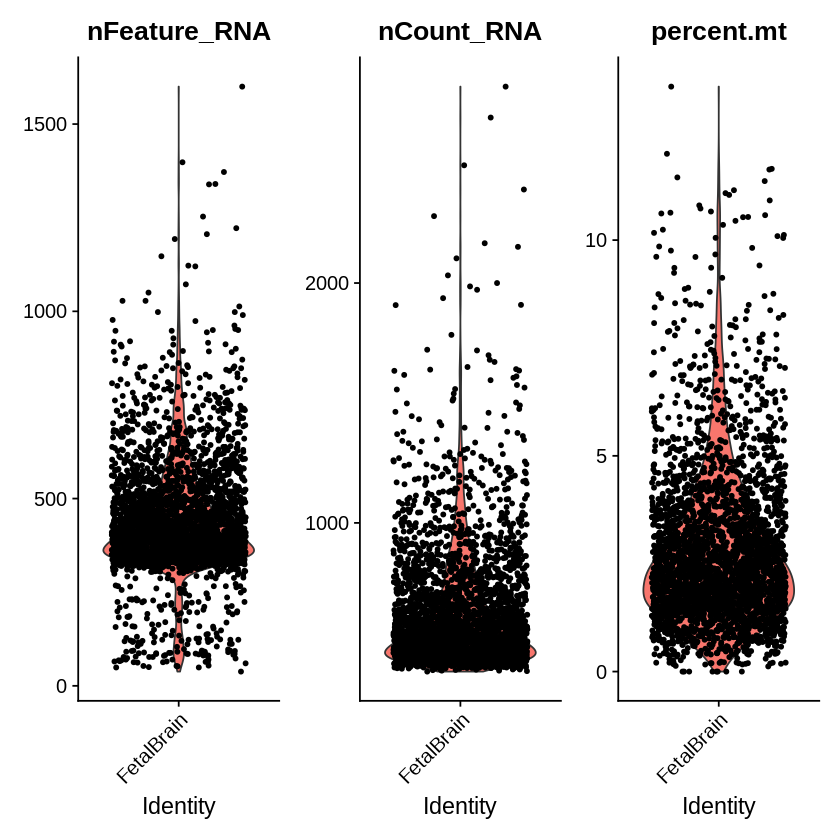

In [21]:
VlnPlot(dataobj, features = c('nFeature_RNA', 'nCount_RNA', 'percent.mt'), ncol = 3)

In [22]:
# QC
nFeature_RNA_range = c(200, 2500)
percent.mt.thre = 10
dataobj <- subset(dataobj, subset = nFeature_RNA > nFeature_RNA_range[1] & nFeature_RNA < nFeature_RNA_range[2] & percent.mt < percent.mt.thre)


In [23]:
# Normalization
# Two approaches
# 1. run standard log normalization 
dataobj <- NormalizeData(dataobj, normalization.method = "LogNormalize", scale.factor = 10000)
dataobj <- FindVariableFeatures(dataobj, selection.method = 'vst', nfeatures = 2000) # default feature number, nfeatures = 2000
dataobj <- ScaleData(dataobj, features = VariableFeatures(dataobj))
# 2. run sctransform 
# dataobj <- SCTransform(dataobj, vars.to.regress = "percent.mt", do.correct.umi = TRUE, do.scale = TRUE, do.center = TRUE)

Centering and scaling data matrix



In [24]:
# Dimensional Reduction
dataobj <- RunPCA(dataobj, features = VariableFeatures(object = dataobj))
# Determine the ‘dimensionality’ of the dataset according to elbow plot

PC_ 1 
Positive:  STMN2, FABP7, TUBA1A, STMN1, CALM2, NEUROD6, TMSB10, HMGB2, PTTG1, C1orf61 
	   GAP43, CSRP2, RPL7, HMGN2, UBE2C, PTN, RTN1, SOX4, HMGB3, RPL34 
	   RPS3A, CKS2, TUBA1B, MAD2L1, RPL35A, TOP2A, CKS1B, NUF2, CCNB2, RPL37A 
Negative:  SPP1, CCL3, A2M, FTL, AIF1, P2RY12, CCL3L3, CX3CR1, VSIG4, B2M 
	   CCL4, TREM2, CTSB, LAPTM5, TYROBP, ITM2B, GPR34, SAMSN1, C1QB, IFNGR1 
	   FCER1G, CTSC, OLFML3, C3, S100A11, CD53, CCL4L2, BTG2, FOLR2, APOC1 
PC_ 2 
Positive:  STMN2, NEUROD6, ID2, GAP43, RTN1, TMSB10, SOX4, TUBA1A, STMN4, HBA2 
	   HBA1, HBG2, HBG1, CNTNAP2, HMP19, HBB, KIDINS220, BCL11A, GNG3, AHSP 
	   ALAS2, CSRP2, LINC00643, RPL34, ARG2, HBM, SATB2, GLRX, FABP6, CRABP1 
Negative:  HMGB2, UBE2C, PTTG1, CKS2, CDK1, TOP2A, NUSAP1, CCNB1, CCNB2, KPNA2 
	   TUBA1B, ARL6IP1, CDKN3, NUF2, HMGN2, CKS1B, CENPF, TTK, KIF2C, CKAP2 
	   MAD2L1, BUB1B, PBK, SMC4, CDC20, DLGAP5, CDCA3, PRC1, AURKB, KNSTRN 
PC_ 3 
Positive:  UBE2C, HMGB2, PTTG1, CKS2, TOP2A, KPNA2, CCNB1, CDK1, CCN

Warning message in ElbowPlot(dataobj, ndims = 100):
“The object only has information for 50 reductions”


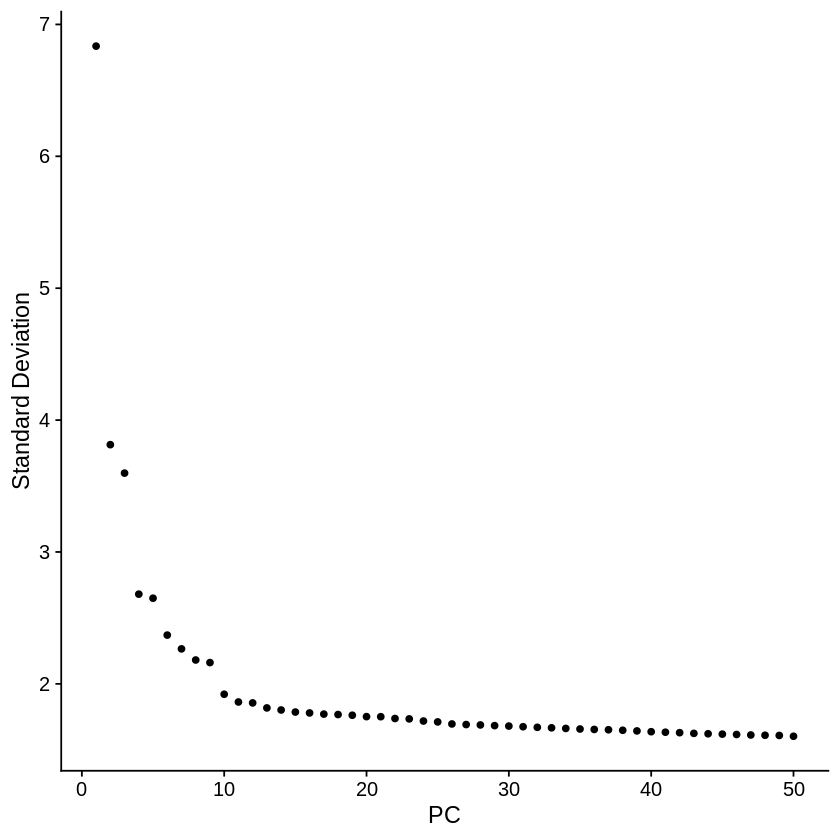

In [25]:
ElbowPlot(dataobj, ndims=100) 
# pdf(paste0(datasetName,"seurat.elbowplot.pdf"))

In [26]:
dev.off()
pcDim = 10 # set as 50 in this case 
dataobj <- RunUMAP(dataobj, dims = 1:pcDim)
DimPlot(dataobj, reduction = "umap", label = TRUE)
# ggsave(paste0(datasetName,".seurat.umap.tiff", plot = p_umap, width = 8, height = 5)

null device 
          1

02:51:10 UMAP embedding parameters a = 0.9922 b = 1.112

02:51:10 Read 2932 rows and found 10 numeric columns

02:51:10 Using Annoy for neighbor search, n_neighbors = 30

02:51:10 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*

|

02:51:11 Writing NN index file to temp file /tmp/RtmpUEfLdo/file3079673d25a9

02:51:11 Searching Annoy index using 1 thread, search_k = 3000

02:51:12 Annoy recall = 100%

02:51:12 Commencing smooth kNN distance calibration using 1 thread

02:51:13 Initializing from normalized Laplacian + noise

02:51:13 Commencing optimization for 500 epochs, with 119636 positive edges

02:51:20 Optimization finished



In [27]:
# Cluster the cells
dataobj <- FindNeighbors(dataobj, reduction = "pca", dims = 1:pcDim, nn.eps = 0.5)
dataobj <- FindClusters(dataobj, resolution = 1)
# umap
dataobj <- RunUMAP(dataobj, dims = 1:pcDim)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2932
Number of edges: 98109

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7754
Number of communities: 10
Elapsed time: 0 seconds


02:51:20 UMAP embedding parameters a = 0.9922 b = 1.112

02:51:20 Read 2932 rows and found 10 numeric columns

02:51:20 Using Annoy for neighbor search, n_neighbors = 30

02:51:20 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*

|

02:51:21 Writing NN index file to temp file /tmp/RtmpUEfLdo/file30793fb38816

02:51:21 Searching Annoy index using 1 thread, search_k = 3000

02:51:22 Annoy recall = 100%

02:51:22 Commencing smooth kNN distance calibration using 1 thread

02:51:23 Initializing from normalized Laplacian + noise

02:51:23 Commencing optimization for 500 epochs, with 119636 positive edges

02:51:30 Optimization finished



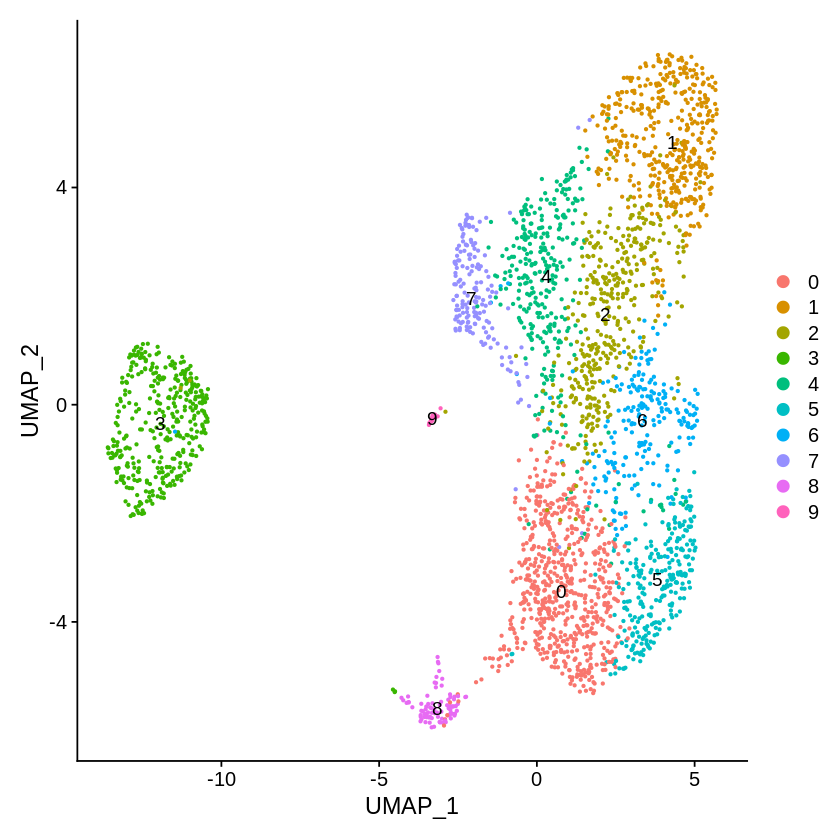

In [28]:
p_umap <- DimPlot(dataobj, reduction = "umap", label = TRUE)
p_umap

In [29]:
ggsave(paste0(datasetName,".seurat.umap.tiff"), plot = p_umap, width = 8, height = 5)

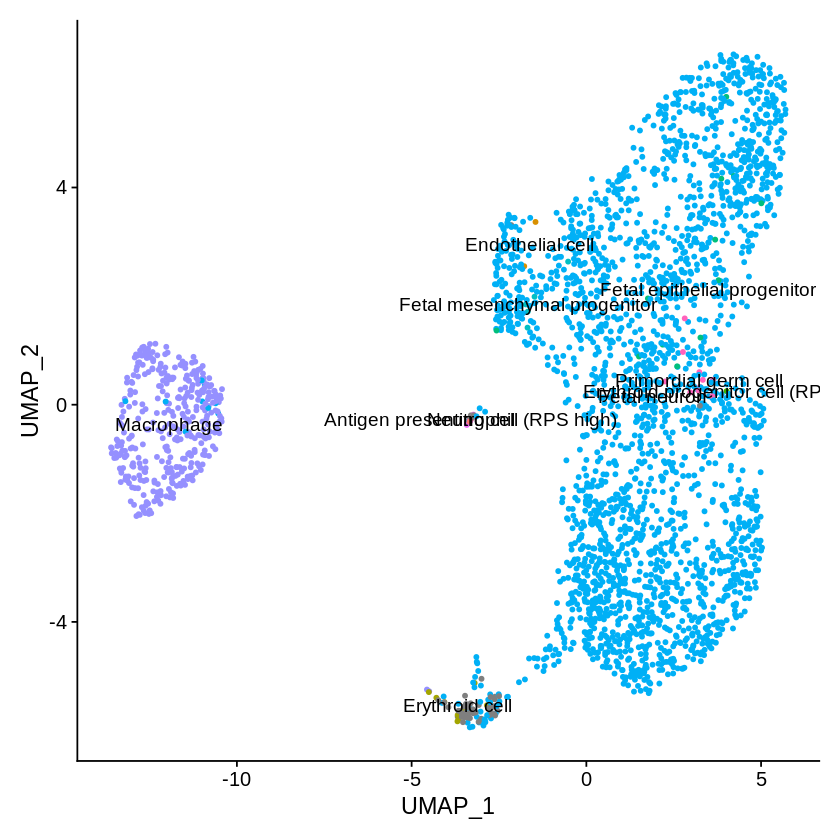

In [30]:
p_umap2 <- DimPlot(dataobj, reduction = "umap", label = TRUE, group.by = "cell_cluster", pt.size=1) + NoLegend()
p_umap2

In [31]:
ggsave(paste0(datasetName,".seurat.umap_orig.tiff"), plot = p_umap2, width = 8, height = 5)

In [17]:
# Finding cluster markers 
dataobj.markers <- FindAllMarkers(dataobj, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
write.table(dataobj.markers, file = paste0(datasetName,".seurat.markers.txt"), sep = "\t", quote = F, row.names = F, col.names = T)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9



In [32]:
new.cluster.ids <- c('Brain-Nerve tissue-Neuron-NEUROD6', 'Proliferating cell-CDK1', 'Proliferating cell-PCNA',
                    'Brain-Nerve tissue-Microglia-AIH and P2RY12', 'Brain-Nerve tissue-Astrocyte-VIM', 'Brain-Nerve tissue-Neuron-NEUROD6',
                    'Unknown', 'Brain-Nerve tissue-Astrocyte-VIM', 'Brain-Epithelial tissue-Erythroid cell-HBA1 and HBA2', 
                     'Unknown')
names(new.cluster.ids) <- levels(dataobj)
dataobj <- RenameIdents(dataobj, new.cluster.ids)

In [12]:
new.cluster.ids <- c('Brain-Nerve tissue-Neuron-NEUROD6', 'Proliferating cell-CDK1', 'Proliferating cell-PCNA',
                    'Brain-Nerve tissue-Microglia-AIH and P2RY12', 'Brain-Nerve tissue-Astrocyte-VIM', 'Brain-Nerve tissue-Neuron-NEUROD6',
                    'Unknown', 'Brain-Nerve tissue-Astrocyte-VIM', 'Brain-Epithelial tissue-Erythroid cell-HBA1 and HBA2', 
                     'Unknown')
names(new.cluster.ids) <- levels(dataobj)
dataobj <- RenameIdents(dataobj, new.cluster.ids)

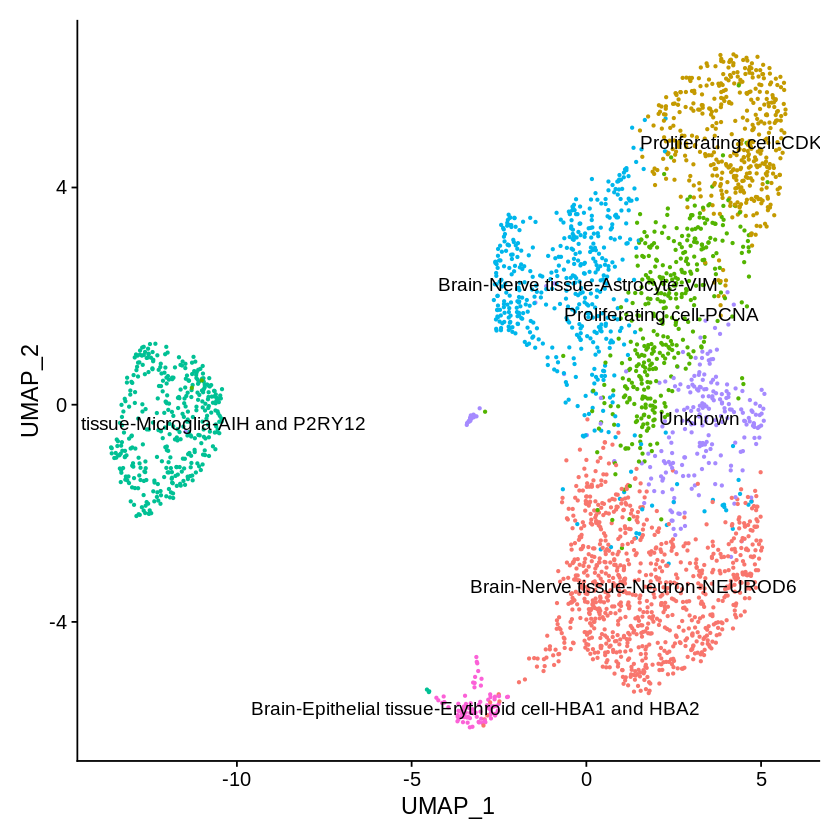

In [33]:
p_umap2 <- DimPlot(dataobj, reduction = "umap", label = TRUE) + NoLegend()
p_umap2

In [34]:
ggsave(paste0(datasetName,".seurat.umap_hcad.tiff"), plot = p_umap2, width = 8, height = 5)

In [35]:
saveRDS(dataobj, file = paste0(datasetName,".seuratobj.rds"))